In [1]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding, LSTM
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.datasets import imdb
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=5000)

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
D:\Anaconda\envs\lstm-env\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
D:\Anaconda\envs\lstm-env\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you mea

In [3]:
X_train = sequence.pad_sequences(X_train, maxlen=100)
X_test = sequence.pad_sequences(X_test, maxlen=100)

In [4]:
model = Sequential()
model.add(Embedding(5000, 100))
model.add(Dropout(0.5))
model.add(Conv1D(64, 5, padding='valid', activation = 'relu', strides = 1))
#Conv1d에서 출력이 5면 양옆 2개를 짤라서 내보내는것이다. stride 1 마스크가 이동시 한칸씩 이동한다는것임
#padding valid옵션을 주면 사이즈 변환을 시키지 않는다. 
model.add(MaxPooling1D(pool_size=4))
#1차원데이터에 맥스풀링
model.add(LSTM(55))
model.add(Dense(1))
model.add(Activation('sigmoid')) #액티베이션 클래스로 객체를 만든것으로 앞선 방식들과 같다. 

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         500000    
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 64)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 55)                26400     
_________________________________________________________________
dense (Dense)                (None, 1)                 56        
_________________________________________________________________
activation (Activation)      (None, 1)                 0

## LSTM 변수개수 구하는 공식
쉽게 예를 들면 

params = 4 * ((size_of_input + 1) * size_of_output + size_of_output^2)
Additional 1 comes from bias terms. So n is size of input (increased by the bias term) and m is size of output of a LSTM layer.


- input :64 <== Embedding 레이어에서 64으로

- output :55 <== LSTM 첫번째 인자

- 4 * ((64 + 1) * 55 + 55^2) = 26,400 

## 해석에 대한 내 생각
- 4는 LSTM층의 노드 하나에 있는 게이트의 갯수로 이 게이트의 갯수에 곱하여 전체 가중치 갯수가 늘어나는것이다.
- ((64+1)*55)는 각 LSTM 노드로 들어오는 이전층의 가중치와 바이어스 값을 LSTM층의 노드갯수 만큼 곱하는 것이다.
- 55*55는 LSTM층의 각 노드마다 여러번 반복한 끝에 구한 1개의 결과를 각각의 노드끼리 공유, 비교하여 출력을 정하는것이다. 

In [9]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [11]:
hist = model.fit(X_train, y_train, batch_size=100, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
250/250 [==============================] - 13s 54ms/step - loss: 0.4544 - accuracy: 0.7681 - val_loss: 0.3357 - val_accuracy: 0.8502
Epoch 2/10
250/250 [==============================] - 13s 51ms/step - loss: 0.2933 - accuracy: 0.8768 - val_loss: 0.3224 - val_accuracy: 0.8578
Epoch 3/10
250/250 [==============================] - 13s 51ms/step - loss: 0.2450 - accuracy: 0.9009 - val_loss: 0.3411 - val_accuracy: 0.8518
Epoch 4/10
250/250 [==============================] - 13s 52ms/step - loss: 0.2124 - accuracy: 0.9180 - val_loss: 0.3500 - val_accuracy: 0.8538
Epoch 5/10
250/250 [==============================] - 13s 51ms/step - loss: 0.1809 - accuracy: 0.9321 - val_loss: 0.3679 - val_accuracy: 0.8531
Epoch 6/10
250/250 [==============================] - 13s 52ms/step - loss: 0.1513 - accuracy: 0.9433 - val_loss: 0.3759 - val_accuracy: 0.8476
Epoch 7/10
250/250 [==============================] - 13s 52ms/step - loss: 0.1312 - accuracy: 0.9518 - val_loss: 0.4167 - val_accuracy:

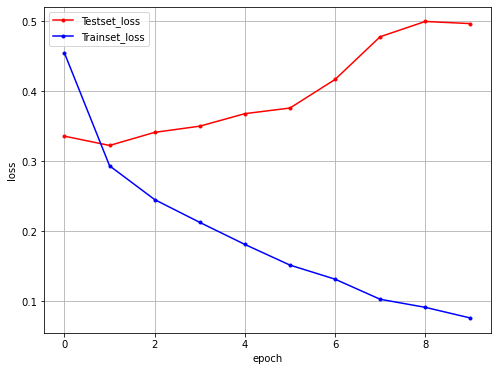

In [13]:
y_vloss = hist.history['val_loss']
y_loss = hist.history['loss']

x_len = np.arange(len(y_loss))
plt.figure(figsize=(8,6))
plt.plot(x_len, y_vloss, marker='.', c='red', label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='Trainset_loss')
plt.legend()
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [14]:
#그래프를 보면 과대적합이 된걸로 보이는데 교재 처럼 epoch수를 3~5정도만 해줘도 좋을 뻔했다...